# Modeling Complex Time Series

In [2]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.arima_process import ArmaProcess
from statsmodels.tsa.stattools import adfuller
from tqdm import tqdm_notebook
from itertools import product

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

## Identifying a stationary ARMA process

#### ARMA(1,1) Process Equation

The equation for the ARMA(1,1) process defined in the code is:

$$
y_t = \phi_1 y_{t-1} + \theta_1 \epsilon_{t-1} + \epsilon_t
$$

Where:

- $ y_t $ is the value of the time series at time $ t $.
- $ \phi_1 = -0.33 $ is the coefficient for the autoregressive part (AR(1)).
- $ \theta_1 = 0.9 $ is the coefficient for the moving average part (MA(1)).
- $ \epsilon_t $ is the white noise error term at time $t $.
- $ \epsilon_{t-1} $ is the white noise error term at the previous time step.

$$
y_t = -0.33 * y_{t-1} + 0.9 * \epsilon_{t-1} + \epsilon_t
$$


In [5]:
np.random.seed(42)

ar1 = np.array([1, -0.33])  # AR(1)
ma1 = np.array([1, 0.9])    # MA(1)

ARMA_1_1 = ArmaProcess(ar1, ma1).generate_sample(nsample=1000)  # Generate the ARMA(1,1) process sample

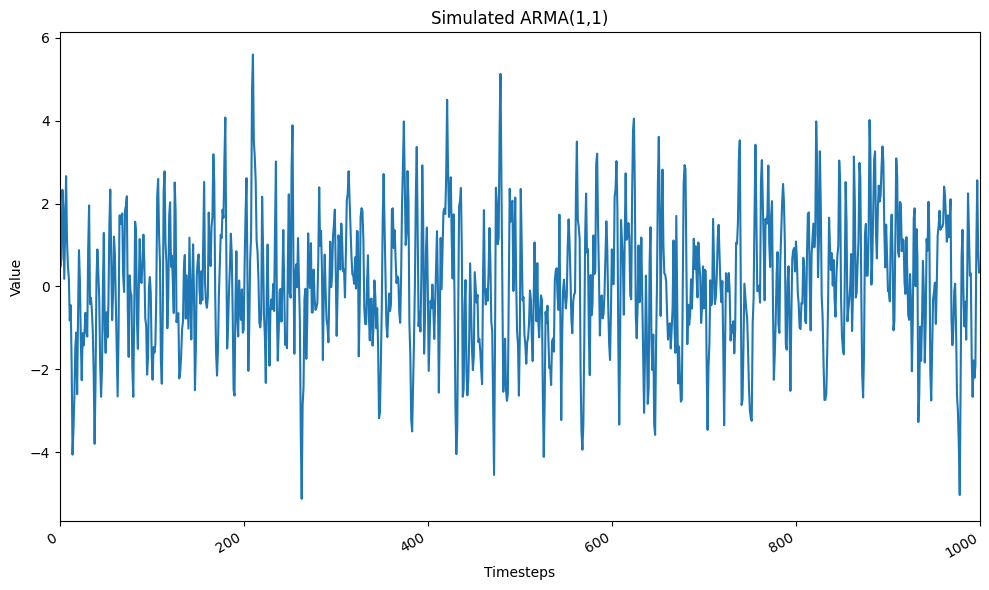

In [6]:
fig, ax = plt.subplots(figsize=(10, 6))

ax.plot(ARMA_1_1)
ax.set_xlabel('Timesteps')
ax.set_ylabel('Value')
ax.set_title('Simulated ARMA(1,1)')

ax.set_xlim(0, 1000) 

fig.autofmt_xdate()
plt.tight_layout()

In [7]:
# Run the Augmented Dickey-Fuller (ADF) test
adf_result = adfuller(ARMA_1_1)

# Display ADF test result
print(f"ADF Statistic: {adf_result[0]}")
print(f"p-value: {adf_result[1]}")
print()

if adf_result[1] < 0.05:
    print("p-value < alpha; Ha: Stationary")
else:
    print("p-value > alpha; H0: Not Stationary")

ADF Statistic: -6.429878682042673
p-value: 1.7078466680098482e-08

p-value < alpha; Ha: Stationary


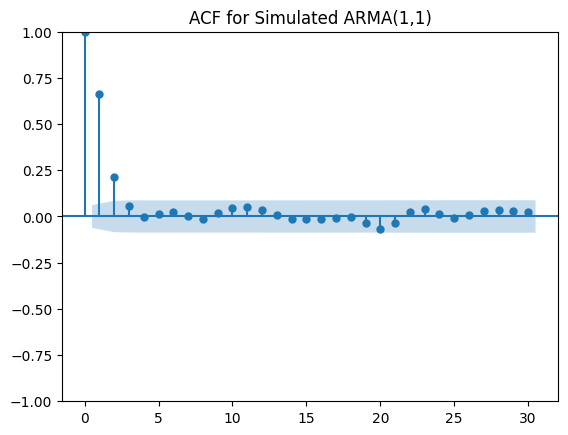

In [8]:
# Plot Auto Correlation Function
plot_acf(ARMA_1_1, lags=30);

plt.title('ACF for Simulated ARMA(1,1)')

plt.show()

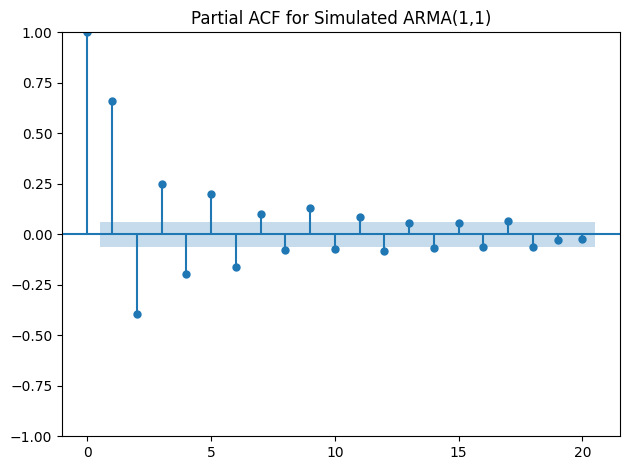

In [9]:
# Plot Partial Auto Correlation Function
plot_pacf(ARMA_1_1, lags=20);

plt.title('Partial ACF for Simulated ARMA(1,1)')

plt.tight_layout()

PACF plot of our simulated ARMA(1,1) process. Again, we have a
sinusoidal pattern with no clear cutoff between significant and non-significant
coefficients. From this plot, we cannot infer that p = 1 in our simulated
ARMA(1,1) process, meaning that we cannot determine the order p of an
ARMA(p,q) process using a PACF plot.

Identifying a stationary ARMA(p,q) process: If your process is stationary and both the ACF and PACF plots show a decaying or sinusoidal pattern, then it is a stationary ARMA(p,q) process.

### Akaike Information Criterion (AIC) - Selecting the best model

In [13]:
ps = range(0, 4, 1)      # Create a list of possible values for p starting from 0 inclusively to 4 exclusively, with steps of 1.
qs = range(0, 4, 1)      # Create a list of possible values for q starting from 0 inclusively to 4 exclusively, with steps of 1.

order_list = list(product(ps, qs)) # Generate a list containing all unique combinations of (p,q).

print(order_list)

[(0, 0), (0, 1), (0, 2), (0, 3), (1, 0), (1, 1), (1, 2), (1, 3), (2, 0), (2, 1), (2, 2), (2, 3), (3, 0), (3, 1), (3, 2), (3, 3)]


In [14]:
from typing import Union

# Define the function optimize_ARMA with input parameters endog and order_list
def optimize_ARMA(endog: Union[pd.Series, list], order_list: list) -> pd.DataFrame:
    
    results = []
    
    for order in tqdm_notebook(order_list):    # Iterate through the list of (p, q) orders with a progress bar
        try:                                   # Fit the SARIMAX model with given (p,q) order
            model = SARIMAX(endog, order=(order[0], 0, order[1]), simple_differencing=False).fit(disp=False)  
        except:
            continue                           # Skip to the next iteration if there's an error in fitting the model
            
        aic = model.aic                        # Get the AIC value of the fitted model
        results.append([order, aic])           # Append the (order, AIC) pair to the results list
        
    result_df = pd.DataFrame(results)          # Convert the results list into a DataFrame
    result_df.columns = ['(p,q)', 'AIC']       # Rename columns to '(p,q)' and 'AIC'
    
    #Sort in ascending order, lower AIC is better
    result_df = result_df.sort_values(by='AIC', ascending=True).reset_index(drop=True)
    
    return result_df

Fit an ARMA(p,q) model using the SARIMAX function. We specify `simple_differencing=False` to prevent differencing. Recall that differencing is the result of yt – yt–1. We also specify `disp=False` to avoid printing convergence messages to the console.

In [16]:
# Fit the different ARMA(p,q) models on the simulated ARMA(1,1) data
result_df = optimize_ARMA(ARMA_1_1, order_list)

result_df

  0%|          | 0/16 [00:00<?, ?it/s]

,"(p,q)",AIC
0,"(1, 1)",2801.407785
1,"(2, 1)",2802.906070
2,"(1, 2)",2802.967762
3,"(0, 3)",2803.666793
4,"(1, 3)",2804.524027
5,"(3, 1)",2804.588567
6,"(2, 2)",2804.822282
7,"(3, 3)",2806.081599
8,"(2, 3)",2806.175380
9,"(3, 2)",2806.894930


*Resulting DataFrame from fitting all
ARMA(p,q) models to the simulated ARMA(1,1)
data. We can see that the model with the lowest
AIC corresponds to an ARMA(1,1) model, meaning
that we successfully identified the order of our
simulated data.*

## Understanding Residual Analysis

#### QUALITATIVE ANALYSIS: STUDYING THE Q-Q PLOT

The Q-Q plot is a graphical tool for verifying our hypothesis that the model’s residuals
are normally distributed.

#### Quantile-quantile plot (Q-Q plot)
A Q-Q plot is a plot of the quantiles of two distributions against each other. In time
series forecasting, we plot the distribution of our residuals on the y-axis against the
theoretical normal distribution on the x-axis.

This graphical tool allows to us to assess the goodness of fit of our model. If the distribution of our residuals is similar to a normal distribution, we will see a straight line
lying on y = x. This means that our model is a good fit, because the residuals are
similar to white noise.
    
On the other hand, if the distribution of our residuals is different from a normal distribution, we will see a curved line. We can then conclude that our model is not a good
fit, since the residuals’ distribution is not close to a normal distribution, and therefore
the residuals are not similar to white noise.

In [20]:
from statsmodels.graphics.gofplots import qqplot

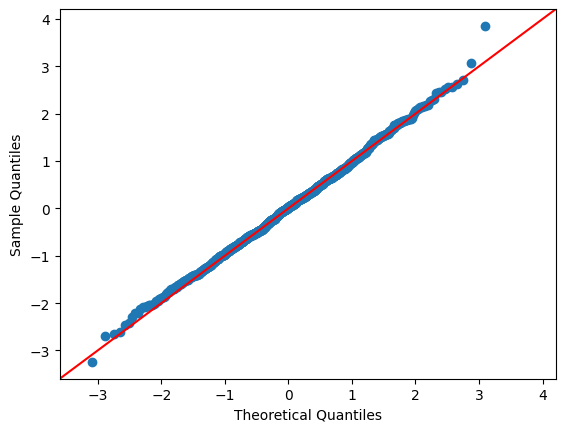

In [21]:
# Seed 42
np.random.seed(42)

# Generate 1000 random samples from a normal distribution with mean=0 and standard deviation=1
normal = np.random.normal(loc=0, scale=1, size=1000)  

# Generate a Q-Q plot of the normal distribution against a theoretical normal distribution with a reference line at 45 degrees
qqplot(normal, line='45');  

A Q-Q plot of randomly distributed residuals. On the y-axis, we
have the quantiles coming from the residuals. On the x-axis, we have the
quantiles coming from a theoretical normal distribution. You can see a
straight line approximately lying on y = x. This is an indication that our
residuals are very close to a normal distribution.

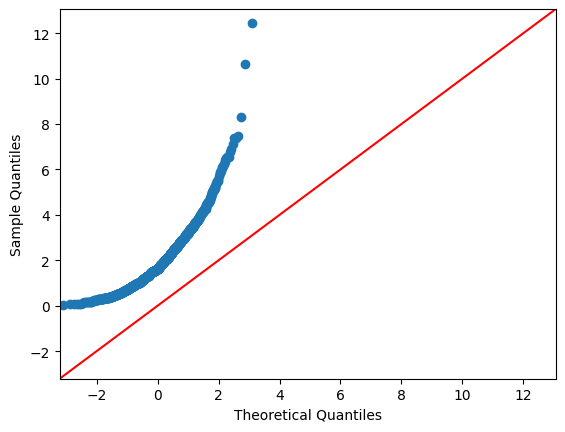

In [23]:
# Generate 1000 random samples from a Gamma distribution with shape=2 using the default random generator
gamma = np.random.default_rng().standard_gamma(shape=2, size=1000)  

# Generate a Q-Q plot of the gamma distribution against a theoretical normal distribution with a reference line at 45 degrees
qqplot(gamma, line='45');  

A Q-Q plot of residuals that are not close to a normal
distribution. You can clearly see that the thick line is curved, and it is not
lying on y = x. Therefore, the distribution of the residuals is very different
from a normal distribution.

### Ljung-Box test
The Ljung-Box test is a statistical test that determines whether the autocorrelation of
a group of data is significantly different from 0.

In time series forecasting, we apply the Ljung-Box test on the model’s residuals to
test whether they are similar to white noise. The null hypothesis states that the data
is independently distributed, meaning that there is no autocorrelation. 
    
If the p-value
is larger than 0.05, we cannot reject the null hypothesis, meaning that the residuals
are independently distributed. Therefore, there is no autocorrelation, the residuals
are similar to white noise, and the model can be used for forecasting.

    P-value > 0.05; H0: Residuals are independetly distributed and uncorrelated 
    P-value < 0.05; Ha: Residuals are autocorrelated

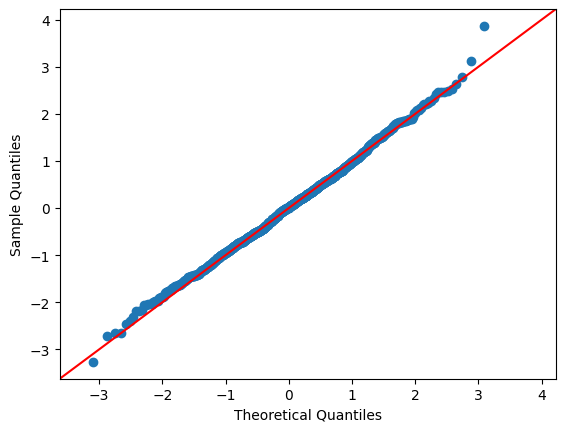

In [27]:
# Create a SARIMAX model with AR(1) and MA(1) terms for the ARMA(1,1) process
model = SARIMAX(ARMA_1_1, order=(1, 0, 1), simple_differencing=False)  

# Fit the model to the ARMA_1_1 data, suppressing output during fitting
model_fit = model.fit(disp=False) 

# Extract the residuals (errors) from the fitted model
residuals = model_fit.resid  

# Generate a Q-Q plot of the residuals to assess if they follow a normal distribution, with the reference line at 45 degrees
qqplot(residuals, line='45');

*Q-Q plot of our ARMA(1,1) residuals. You can see a thick straight
line lying on y = x. This means that our residuals are normally distributed, just
like white noise.*

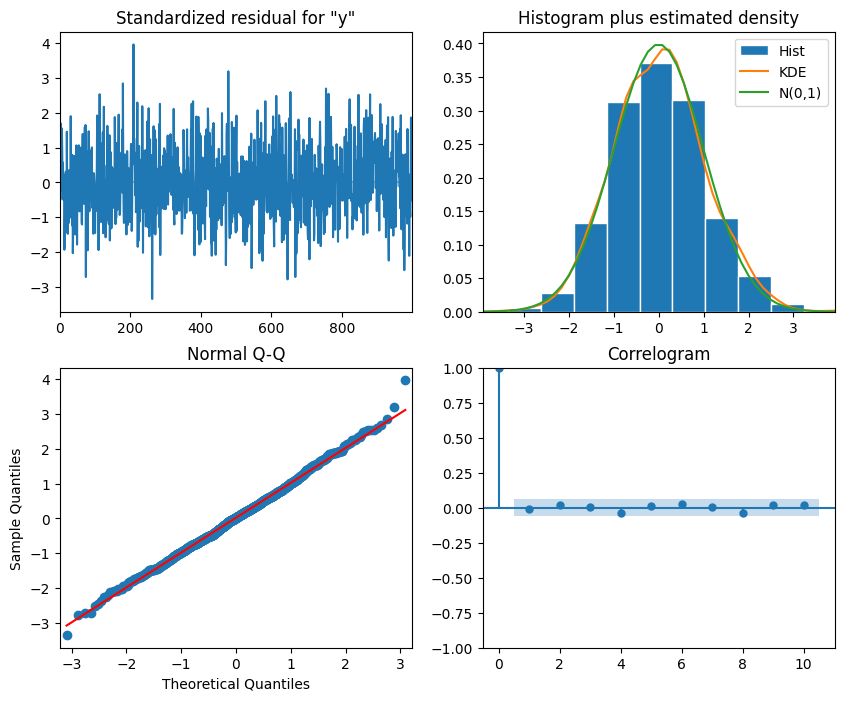

In [29]:
# Diagnostic plots for the model, including residuals and other model checks
model_fit.plot_diagnostics(figsize=(10, 8));  

The **top-left plot** shows the residuals across the entire dataset. You can see that
there is no trend, and the mean seems stable over time, which is indicative of stationarity, just like white noise.

The **top-right plot** shows a histogram of the residuals. You can see the shape of a
normal distribution on this plot, which again indicates that the residuals are close to
white noise, as white noise is normally distributed as well.

At the **bottom left**, we have the Q-Q plot, which is identical to figure 6.12, and
therefore leads us to the same conclusion.

Finally, the **bottom-right plot** shows the autocorrelation function of our residuals. You
can see that there is only a significant peak at lag 0, and no significant coefficients otherwise. This means that the residuals are not correlated, which further supports the conclusion that they are similar to white noise, which is what we expect from a good model.

In [31]:
from statsmodels.stats.diagnostic import acorr_ljungbox

# Apply the Ljung-Box test on the residuals, on 10 lags.
df_residuals = acorr_ljungbox(residuals, np.arange(1, 11, 1))

df_residuals

,lb_stat,lb_pvalue
1,0.030706,0.860897
2,0.528021,0.767966
3,0.540904,0.909817
4,2.079774,0.721089
5,2.271897,0.810385
6,2.896262,0.821750
7,2.900378,0.894063
8,4.418799,0.817501
9,4.787567,0.852419
10,5.246805,0.874093


The resulting list of p-values shows that each is above 0.05. Therefore, at each lag, the null hypothesis cannot be rejected, meaning that the residuals are independently distributed and uncorrelated.

    P-value > 0.05; H0: Residuals are independetly distributed and uncorrelated

We can conclude from our analysis that the residuals are similar to white noise.

## Applying the General Modeling Procedure

#### Gather Data

In [35]:
url1 = ('https://raw.githubusercontent.com/marcopeix/TimeSeriesForecastingInPython/refs/heads/master/data/bandwidth.csv')

df = pd.read_csv(url1)

df.head()

,hourly_bandwidth
0,1000.496714
1,1000.969408
2,1002.046019
3,1004.702118
4,1007.447816


#### Plot Data

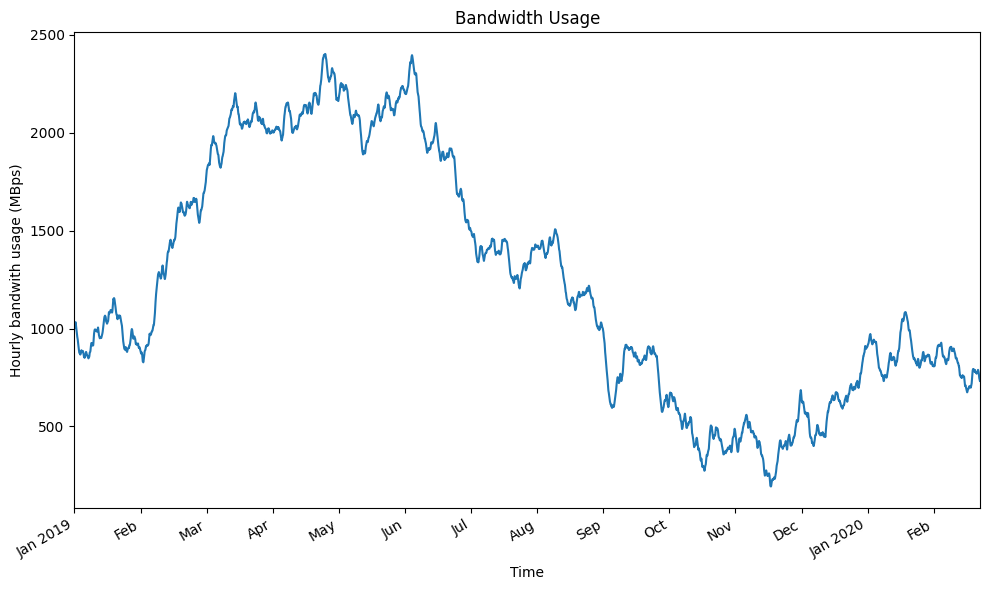

In [37]:
fig, ax = plt.subplots(figsize=(10, 6))

ax.plot(df['hourly_bandwidth'])
ax.set_xlabel('Time')
ax.set_ylabel('Hourly bandwith usage (MBps)')
ax.set_title('Bandwidth Usage')
ax.set_xlim(0, 10000) 

plt.xticks(
    np.arange(0, 10000, 730), 
    ['Jan 2019', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec', 'Jan 2020', 'Feb'])

fig.autofmt_xdate()
plt.tight_layout()

*Hourly bandwidth usage in a data center since January 1, 2019. The dataset contains 10,000 points.*

#### ADF Test

In [40]:
# Augmented Dickey Fuller (ADF): Not stationary (H0), Stationary (Ha)

ADF_result = adfuller(df['hourly_bandwidth'])

print(f'ADF Statistic: {ADF_result[0]}')
print(f'p-value: {ADF_result[1]}')

ADF Statistic: -0.8714653199451807
p-value: 0.7972240255014846


    p-value (0.797) > alpha (0.05); H0: Not stationary

#### Plot ACF

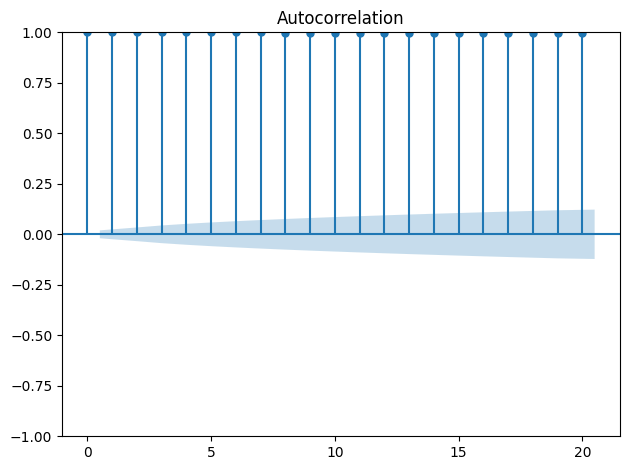

In [43]:
# Auto Correlation Function
plot_acf(df['hourly_bandwidth'], lags=20);

plt.tight_layout()

*Definitely not stationary (all data is autocorrelated).*

#### Apply Transformation

In [46]:
# First-order differencing
bandwidth_diff = np.diff(df.hourly_bandwidth, n=1)

#### Plot Transformed Data

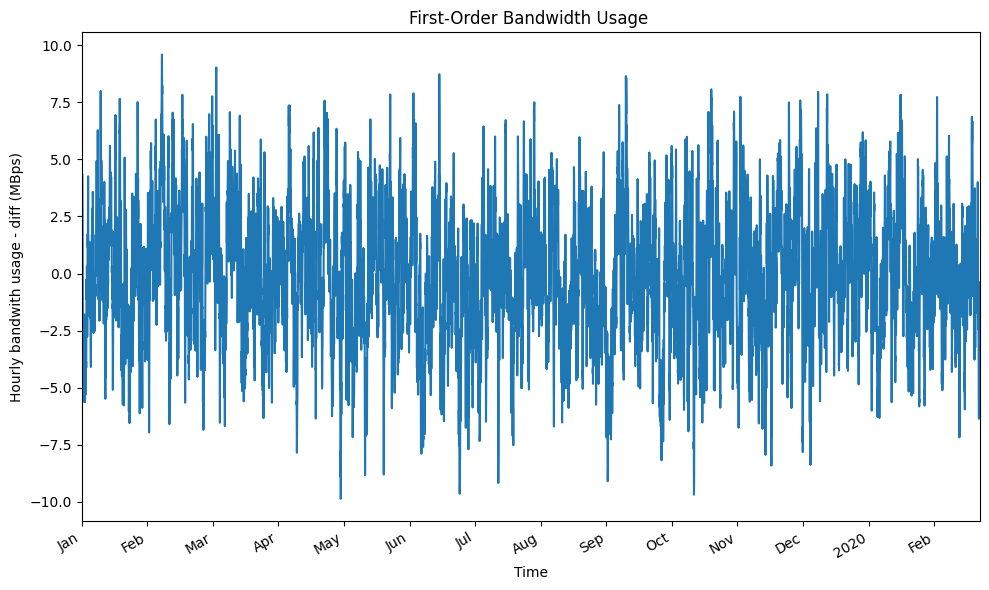

In [48]:
fig, ax = plt.subplots(figsize=(10, 6))

ax.plot(bandwidth_diff)
ax.set_xlabel('Time')
ax.set_ylabel('Hourly bandwith usage - diff (MBps)')
ax.set_title('First-Order Bandwidth Usage ')
ax.set_xlim(0, 10000)

plt.xticks(
    np.arange(0, 10000, 730), 
    ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec', '2020', 'Feb'])

fig.autofmt_xdate()
plt.tight_layout()

#### ADF Test with Transformed Data

In [50]:
# Augmented Dickey Fuller (ADF): Not stationary (H0), Stationary (Ha)

ADF_result2 = adfuller(bandwidth_diff)

print(f'ADF Statistic: {ADF_result2[0]}')
print(f'p-value: {ADF_result2[1]}')

ADF Statistic: -20.694853863789042
p-value: 0.0


    p-value (0.0) < alpha (0.05); Ha: Stationary

#### Plot ACF with Transformed Data

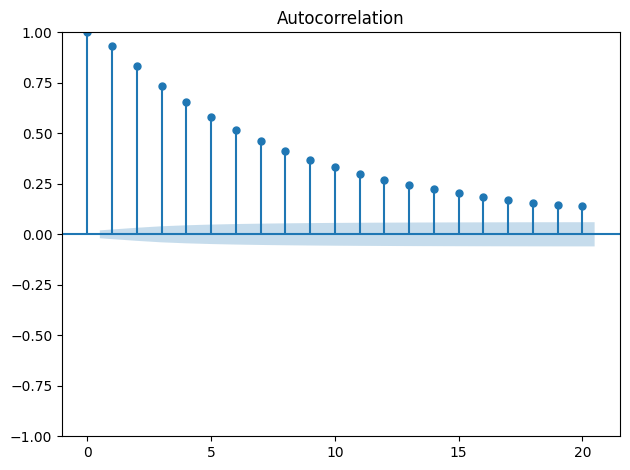

In [53]:
# Auto Correlation Function
plot_acf(bandwidth_diff, lags=20);

plt.tight_layout()

*Stationary!!!*

#### Plot the PACF, and see significant coefficients lags

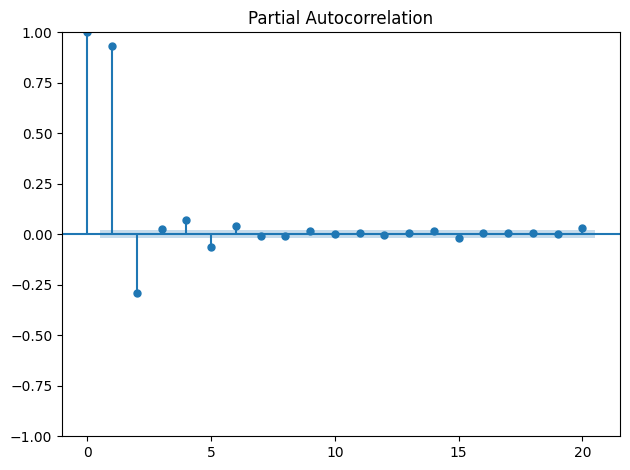

In [56]:
plot_pacf(bandwidth_diff, lags=20);

plt.tight_layout()

We are now ready to start modeling our stationary process using an ARMA(p,q)
model. We’ll split our series into train and test sets. Here we’ll keep the last 7 days of
data for the test set. Since our forecasts are for the next 2 hours, the test set thus contains 84 periods of 2 hours on which to evaluate our models’ performance, since 7 days
of hourly data totals 168 hours.

In [58]:
test_number = 7 * 24
test_number

168

#### Separate the series into train and test sets

In [60]:
df_diff = pd.DataFrame({'bandwidth_diff': bandwidth_diff})

train = df_diff[:-168]  # All data until the last 168 timesteps
test = df_diff[-168:]   # The last 168 timesteps 

print(len(train))
print(len(test))

9831
168


#### Plot Data and First-Order Data

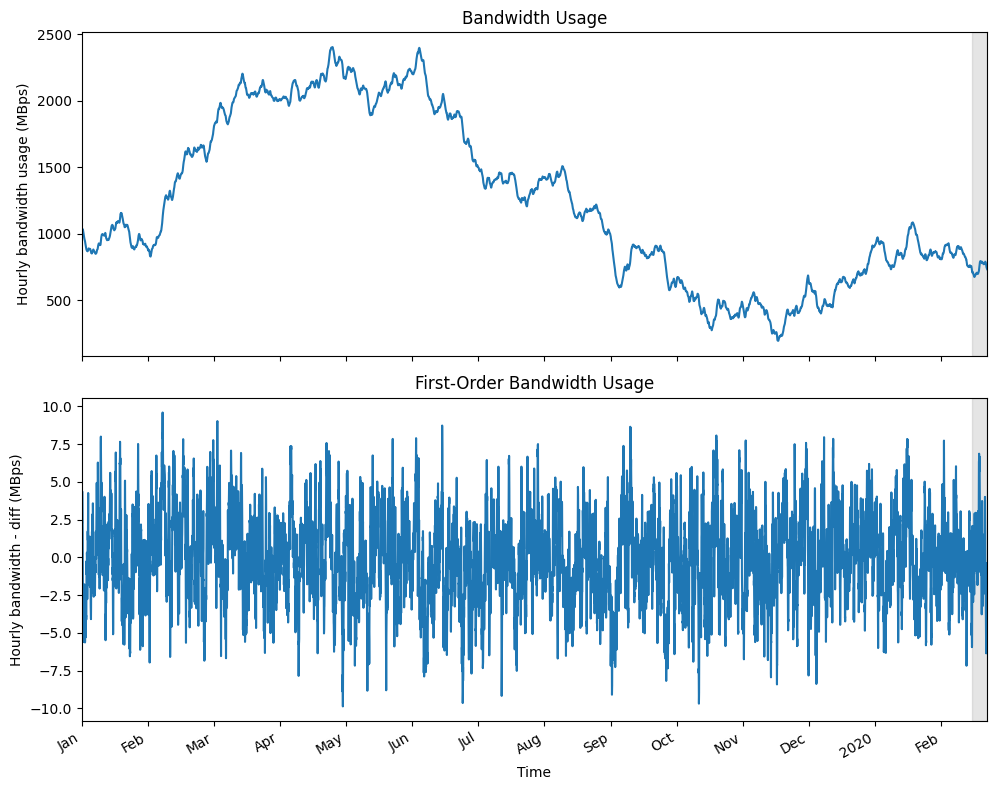

In [62]:
fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, sharex=True, figsize=(10, 8))

ax1.plot(df['hourly_bandwidth'])
ax1.set_xlabel('Time')
ax1.set_ylabel('Hourly bandwidth usage (MBps)')
ax1.axvspan(9831, 10000, color='#808080', alpha=0.2)
ax1.set_title('Bandwidth Usage')
ax1.set_xlim(0, 10000)

ax2.plot(df_diff['bandwidth_diff'])
ax2.set_xlabel('Time')
ax2.set_ylabel('Hourly bandwidth - diff (MBps)')
ax2.axvspan(9830, 9999, color='#808080', alpha=0.2)
ax2.set_title('First-Order Bandwidth Usage')
ax2.set_xlim(0, 10000)

plt.xticks(
    np.arange(0, 10000, 730), 
    ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec', '2020', 'Feb'])

fig.autofmt_xdate()
plt.tight_layout()

*Train and test sets for the original and differenced series.*

#### Function to fit all unique ARMA(p,q) models

In [65]:
from typing import Union

# The function takes as inputs the time series data and the list of unique (p,q) combinations
def optimize_ARMA(endog: Union[pd.Series, list], order_list: list) -> pd.DataFrame:
    
    results = []
    
    for order in tqdm_notebook(order_list):
        try: 
            model = SARIMAX(endog, order=(order[0], 0, order[1]), simple_differencing=False).fit(disp=False)     # Fit an ARMA(p,q) model using SARIMAX
        except:
            continue
            
        aic = model.aic                    # Calculate the model’s AIC.
        results.append([order, aic])       # Append the (p,q) combination and AIC as a tuple to the results list.
        
    result_df = pd.DataFrame(results)
    result_df.columns = ['(p,q)', 'AIC']
    
    #Sort in ascending order, lower AIC is better
    result_df = result_df.sort_values(by='AIC', ascending=True).reset_index(drop=True)
    
    return result_df

In [66]:
ps = range(0, 4, 1)                 # The order p can have the values {0,1,2,3}
qs = range(0, 4, 1)                 # The order q can have the values {0,1,2,3}

order_list = list(product(ps, qs))  # Generate the unique (p,q) combinations
order_list

[(0, 0),
 (0, 1),
 (0, 2),
 (0, 3),
 (1, 0),
 (1, 1),
 (1, 2),
 (1, 3),
 (2, 0),
 (2, 1),
 (2, 2),
 (2, 3),
 (3, 0),
 (3, 1),
 (3, 2),
 (3, 3)]

#### Model Selection

In [68]:
# Pass 'train dataset' and 'order_list' on 'optimize_ARMA'
result_df = optimize_ARMA(train['bandwidth_diff'], order_list)  
result_df

  0%|          | 0/16 [00:00<?, ?it/s]

,"(p,q)",AIC
0,"(3, 2)",27991.063879
1,"(2, 3)",27991.287509
2,"(2, 2)",27991.603598
3,"(3, 3)",27993.416924
4,"(1, 3)",28003.349550
5,"(1, 2)",28051.351401
6,"(3, 1)",28071.155496
7,"(3, 0)",28095.618186
8,"(2, 1)",28097.250766
9,"(2, 0)",28098.407664


The resulting DataFrame is shown in figure 6.17. You’ll notice that the first three models all have an AIC of 27,991, with only slight differences. Therefore, I would argue
that the ARMA(2,2) model is the model that should be selected. Its AIC value is very
close to the ARMA(3,2) and ARMA(2,3) models, while being less complex, since it has
four parameters to be estimated instead of five. Therefore, we’ll select the ARMA(2,2)
model and move on to the next steps, which is the analysis of the model’s residuals.

#### Fit Model

In [71]:
# Define a SARIMAX model with specified AR(2), I(0), MA(2) parameters
model = SARIMAX(train['bandwidth_diff'], order=(2,0,2), simple_differencing=False)

# Fit the model
model_fit = model.fit(disp=False)

# Display the summary
model_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:         bandwidth_diff   No. Observations:                 9831
Model:               SARIMAX(2, 0, 2)   Log Likelihood              -13990.802
Date:                Thu, 13 Feb 2025   AIC                          27991.604
Time:                        14:56:26   BIC                          28027.570
Sample:                             0   HQIC                         28003.788
                               - 9831                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.3486      0.052      6.765      0.000       0.248       0.450
ar.L2          0.4743      0.047     10.000      0.000       0.381       0.567
ma.L1          0.8667      0.050     17.249      0.000       0.768       0.965
ma.L2          0.2807      0.015     19.233      0.000       0.252       0.309
sigma2         1.0082      0.014     70.654      0.000       0.980       1.036
===================================================================================
Ljung-Box (L1) (Q):                   0.04   Jarque-Bera (JB):                 0.50
Prob(Q):                              0.84   Prob(JB):                         0.78
Heteroskedasticity (H):               1.06   Skew:                             0.00
Prob(H) (two-sided):                  0.12   Kurtosis:                         3.03
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

#### Diagnostic plots

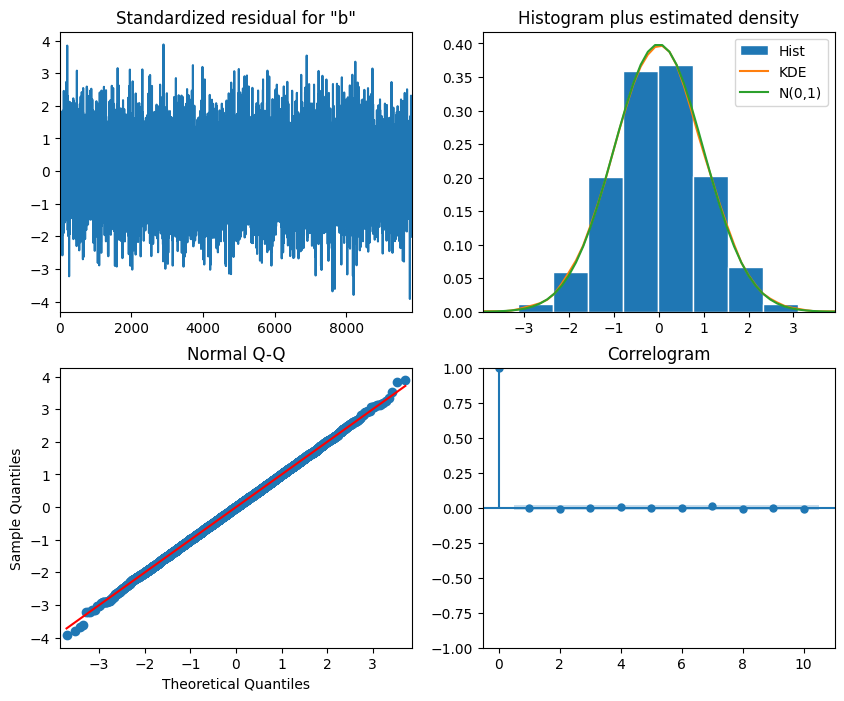

In [73]:
# Diagnostic plots for the model, including residuals and other model checks
model_fit.plot_diagnostics(figsize=(10, 8));

We can see that the top-left plot shows no trend, and the mean seems
constant over time, meaning that our residuals are likely stationary. The top right displays a density plot with a shape similar to that of a normal distribution. The Q-Q plot
at the bottom left shows a thick straight line that is very close to y = x. Finally, the ACF
plot at the bottom right shows no autocorrelation after lag 0. Thus, figure indicates that our residuals clearly resemble white noise, since they are normally distributed and uncorrelated.

####  Ljung-Box test

In [76]:
# Extract the residuals (errors) from the fitted model
residuals = model_fit.resid 

# Apply the Ljung-Box test on the residuals, on 10 lags.
df_residuals = acorr_ljungbox(residuals, np.arange(1, 11, 1))

df_residuals

,lb_stat,lb_pvalue
1,0.042190,0.837257
2,0.418364,0.811247
3,0.520271,0.914416
4,0.850555,0.931545
5,0.850841,0.973678
6,1.111754,0.981019
7,2.124864,0.952607
8,3.230558,0.919067
9,3.248662,0.953615
10,3.588289,0.964015


    P-value > 0.05; H0: Residuals are independetly distributed and uncorrelated

We can conclude from our analysis that the residuals are similar to white noise.

## Forecasting bandwidth usage

#### A function to perform a rolling forecast on a horizon

In [80]:
def rolling_forecast(df: pd.DataFrame, train_len: int, horizon: int, window: int, method: str) -> list:
    
    total_len = train_len + horizon
    end_idx = train_len
    
    if method == 'mean':
        pred_mean = []
        
        for i in range(train_len, total_len, window):
            mean = np.mean(df[:i].values)
            pred_mean.extend(mean for _ in range(window))
            
        return pred_mean

    elif method == 'last':
        pred_last_value = []
        
        for i in range(train_len, total_len, window):
            last_value = df[:i].iloc[-1].values[0]
            pred_last_value.extend(last_value for _ in range(window))
            
        return pred_last_value
    
    elif method == 'ARMA':
        pred_ARMA = []
        
        for i in range(train_len, total_len, window):
            model = SARIMAX(df[:i], order=(2,0,2))    # <==== AR(2), I(0), MA(2) parameters
            res = model.fit(disp=False)
            predictions = res.get_prediction(0, i + window - 1)
            oos_pred = predictions.predicted_mean.iloc[-window:]
            pred_ARMA.extend(oos_pred)
            
        return pred_ARMA

We know from
chapter 4 that predicting beyond q steps into the future with an MA(q) model will simply return the mean, so the predictions will remain flat. We’ll therefore avoid this situation by setting the window to 2. 

In [82]:
TRAIN_LEN = len(train)
HORIZON = len(test)
WINDOW = 2  # <==== minimum value by (q)

pred_mean = rolling_forecast(df_diff, TRAIN_LEN, HORIZON, WINDOW, 'mean')
pred_last_value = rolling_forecast(df_diff, TRAIN_LEN, HORIZON, WINDOW, 'last')
pred_ARMA = rolling_forecast(df_diff, TRAIN_LEN, HORIZON, WINDOW, 'ARMA')

test.loc[:, 'pred_mean'] = pred_mean
test.loc[:, 'pred_last_value'] = pred_last_value
test.loc[:, 'pred_ARMA'] = pred_ARMA

test.head()

,bandwidth_diff,pred_mean,pred_last_value,pred_ARMA
9831,-5.943995,-0.028214,-5.791207,-5.460661
9832,-5.865194,-0.028214,-5.791207,-4.890626
9833,-3.197066,-0.029410,-5.865194,-5.335905
9834,-1.090197,-0.029410,-5.865194,-4.751731
9835,0.665291,-0.029840,-1.090197,-0.375596


#### Plot Forecasting

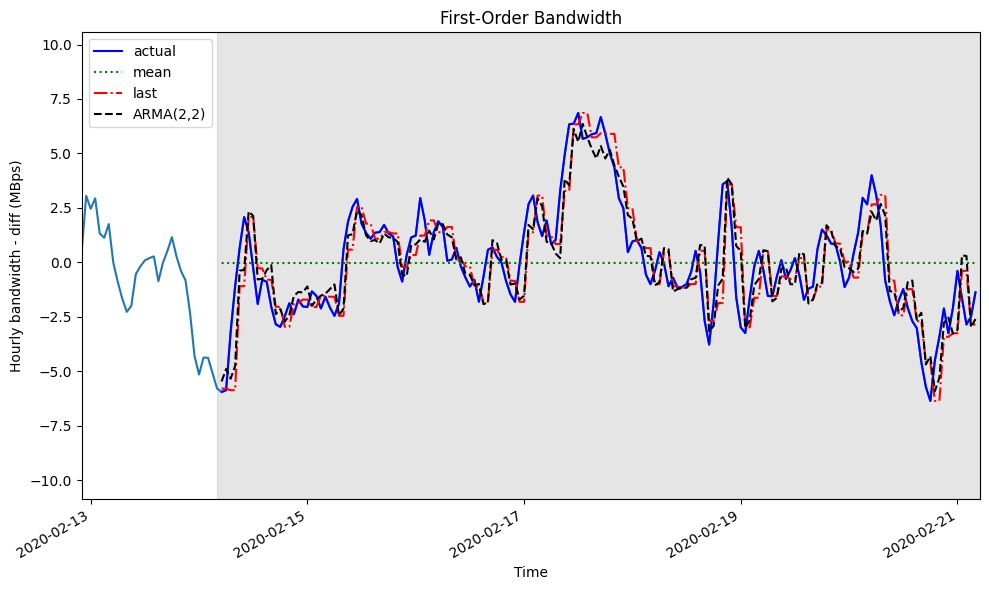

In [84]:
fig, ax = plt.subplots(figsize=(10, 6))

ax.plot(df_diff['bandwidth_diff'])
ax.plot(test['bandwidth_diff'], 'b-', label='actual')
ax.plot(test['pred_mean'], 'g:', label='mean')
ax.plot(test['pred_last_value'], 'r-.', label='last')
ax.plot(test['pred_ARMA'], 'k--', label='ARMA(2,2)')
ax.set_title('First-Order Bandwidth')

ax.legend(loc=2)

ax.set_xlabel('Time')
ax.set_ylabel('Hourly bandwidth - diff (MBps)')

ax.axvspan(9830, 9999, color='#808080', alpha=0.2)

ax.set_xlim(9800, 9999)

plt.xticks(
    [9802, 9850, 9898, 9946, 9994],
    ['2020-02-13', '2020-02-15', '2020-02-17', '2020-02-19', '2020-02-21'])

fig.autofmt_xdate()
plt.tight_layout()

#### Measure the MSE, and identify the champion model

In [86]:
# Calculate the MSE for each forecast
mse_mean = mean_squared_error(test['bandwidth_diff'], test['pred_mean'])
mse_last = mean_squared_error(test['bandwidth_diff'], test['pred_last_value'])
mse_ARMA = mean_squared_error(test['bandwidth_diff'], test['pred_ARMA'])

# Display MSE results
print(f'      MSE (Mean Forecast): {mse_mean:.2f}')
print(f'MSE (Last Value Forecast): {mse_last:.2f}')
print(f'     MSE (MA(2) Forecast): {mse_ARMA:.2f}')

      MSE (Mean Forecast): 6.31
MSE (Last Value Forecast): 2.23
     MSE (MA(2) Forecast): 1.77


#### MSEs in a bar plot

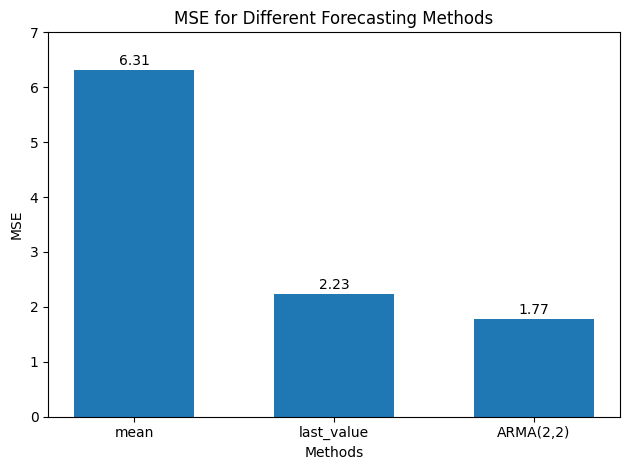

In [88]:
fig, ax = plt.subplots()

x = ['mean', 'last_value', 'ARMA(2,2)']
y = [mse_mean, mse_last, mse_ARMA]

ax.bar(x, y, width=0.6)
ax.set_xlabel('Methods')
ax.set_ylabel('MSE')
ax.set_title('MSE for Different Forecasting Methods')
ax.set_ylim(0, 7)

for index, value in enumerate(y):
    plt.text(x=index, y=value + 0.1, s=str(round(value, 2)), ha='center')

plt.tight_layout()

#### Reverse the Transformation

The final step is to reverse the transformation of our forecast in order to bring it to
the same scale as our original data. Remember that we differenced the original data to
make it stationary. The ARMA(2,2) model was then applied on the stationary dataset
and produced forecasts that are differenced.
To reverse the differencing transformation, we can apply a cumulative sum.

In [91]:
10000 - 168

9832

In [92]:
# Create a new empty column 'pred_bandwidth' in the DataFrame
df['pred_bandwidth'] = pd.Series()

# # Assign cumulative sum of 'pred_ARMA' starting from index 9832, adding the value from 'hourly_bandwidth' at index 9832
df['pred_bandwidth'][9832:] = df['hourly_bandwidth'].iloc[9832] + test['pred_ARMA'].cumsum()

df.tail()

,hourly_bandwidth,pred_bandwidth
9995,740.546059,721.377109
9996,738.906228,721.70246
9997,736.057995,721.996748
9998,733.559640,719.020898
9999,732.190049,716.423855


#### Plot the forecasts on the original scale of the data

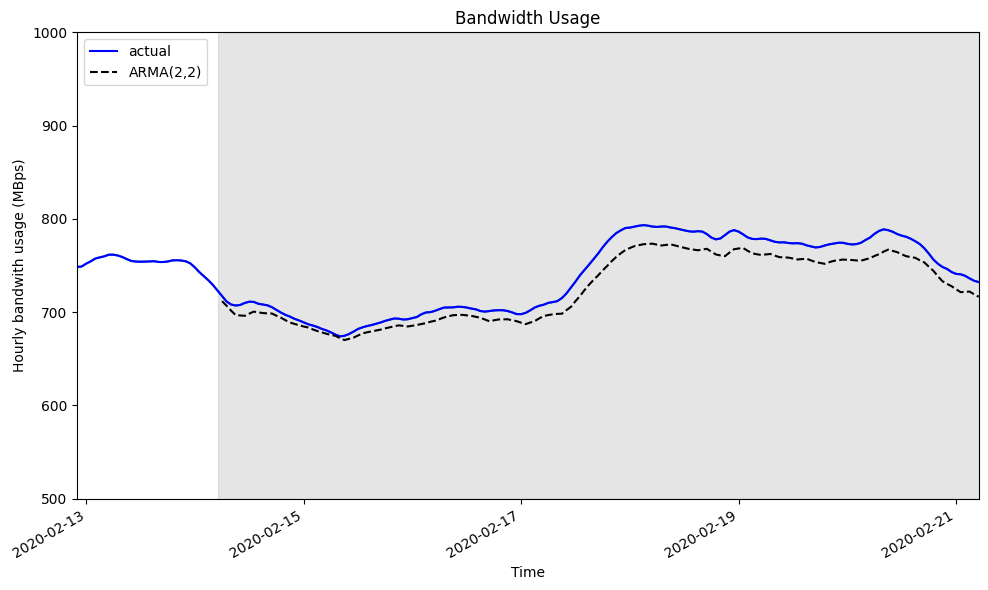

In [94]:
fig, ax = plt.subplots(figsize=(10, 6))

ax.plot(df['hourly_bandwidth'])
ax.plot(df['hourly_bandwidth'], 'b-', label='actual')
ax.plot(df['pred_bandwidth'], 'k--', label='ARMA(2,2)')

ax.legend(loc=2)

ax.set_xlabel('Time')
ax.set_ylabel('Hourly bandwith usage (MBps)')
ax.set_title('Bandwidth Usage')

ax.axvspan(9831, 10000, color='#808080', alpha=0.2)

ax.set_xlim(9800, 9999)
ax.set_ylim(500, 1000)

plt.xticks(
    [9802, 9850, 9898, 9946, 9994],
    ['2020-02-13', '2020-02-15', '2020-02-17', '2020-02-19', '2020-02-21'])

fig.autofmt_xdate()
plt.tight_layout()

*Undifferenced predictions of hourly bandwidth usage. Notice how the
dashed line representing our predictions almost coincides with the solid line
representing the actual values. This means that our predictions are very close to the
actual values, indicating a performant model.*

#### Measure the MAE of the undifferenced Model

In [97]:
# Measure the mean absolute error (MAE) of the undifferenced ARMA(2,2)

mae_ARMA_undiff = mean_absolute_error(df['hourly_bandwidth'][9832:], df['pred_bandwidth'][9832:])

print("MAE for undifferenced ARMA(2,2):", mae_ARMA_undiff.round(2))

MAE for undifferenced ARMA(2,2): 14.0


MAE of 14, meaning that, on average, our forecasts are 14 Mbps above or below the actual bandwidth usage.